# 1. Training Model

Found 35669 images belonging to 19 classes.
Found 8917 images belonging to 19 classes.
Training the model...


C:\Users\AMAN KUMAR\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6788 - loss: 1.0550

C:\Users\AMAN KUMAR\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1115/1115 ━━━━━━━━━━━━━━━━━━━━ 1851s 2s/step - accuracy: 0.6789 - loss: 1.0546 - val_accuracy: 0.9421 - val_loss: 0.1882 - learning_rate: 0.0010
Epoch 2/20
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 1872s 2s/step - accuracy: 0.9003 - loss: 0.2911 - val_accuracy: 0.9428 - val_loss: 0.1681 - learning_rate: 0.0010
Epoch 3/20
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 1795s 2s/step - accuracy: 0.9106 - loss: 0.2557 - val_accuracy: 0.9548 - val_loss: 0.1349 - learning_rate: 0.0010
Epoch 4/20
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 1747s 2s/step - accuracy: 0.9123 - loss: 0.2473 - val_accuracy: 0.9586 - val_loss: 0.1235 - learning_rate: 0.0010
Epoch 5/20
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 1715s 2s/step - accuracy: 0.9199 - loss: 0.2330 - val_accuracy: 0.9531 - val_loss: 0.1388 - learning_rate: 0.0010
Epoch 6/20
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 1711s 2s/step - accuracy: 0.9183 - loss: 0.2397 - val_accuracy: 0.9505 - val_loss: 0.1454 - learning_rate: 0.0010
Epoch 7/20
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 5839s 5s/step - accuracy: 0.9172 

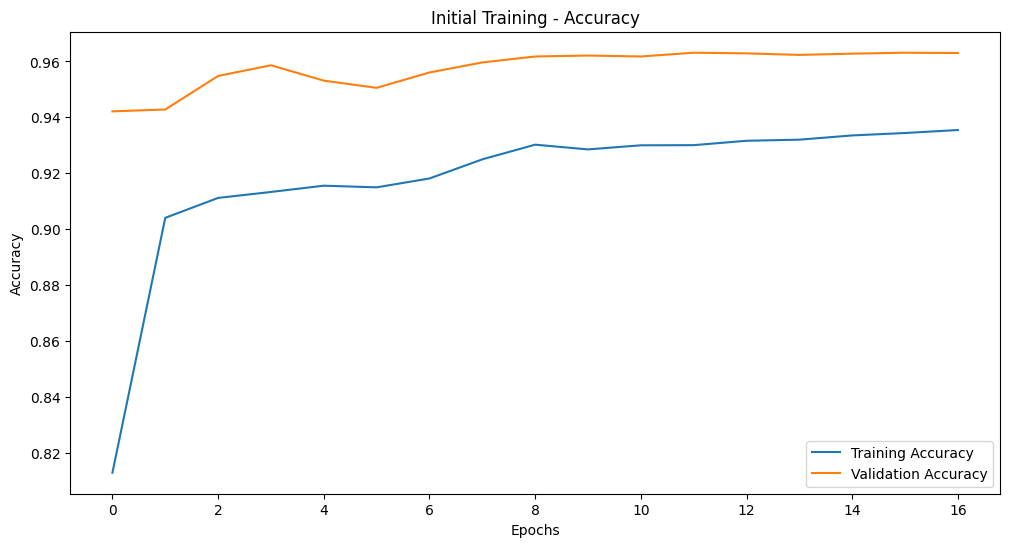

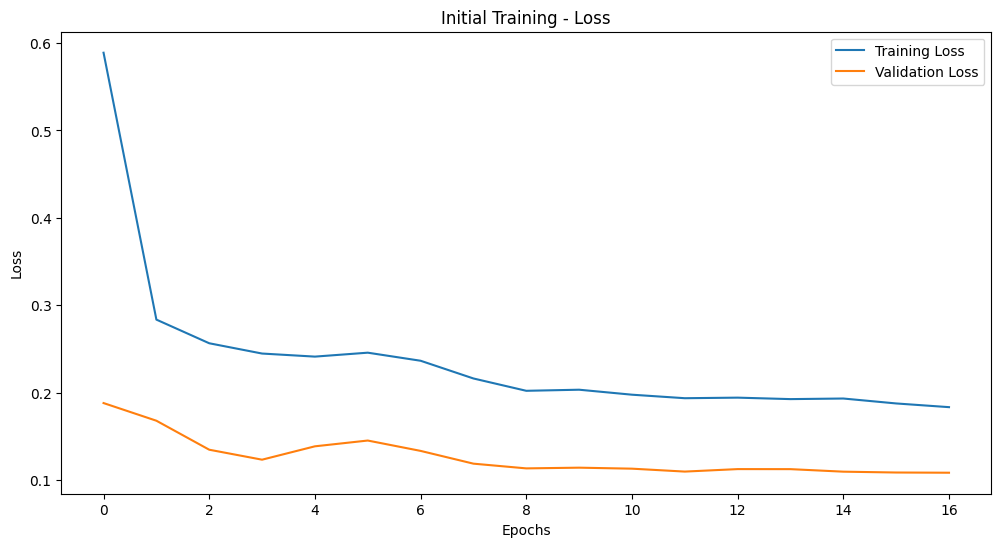

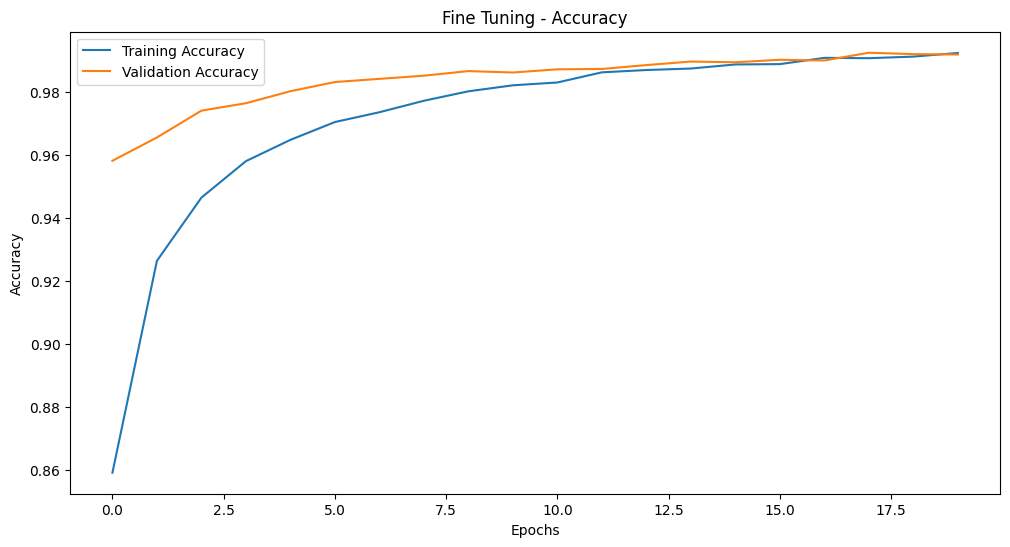

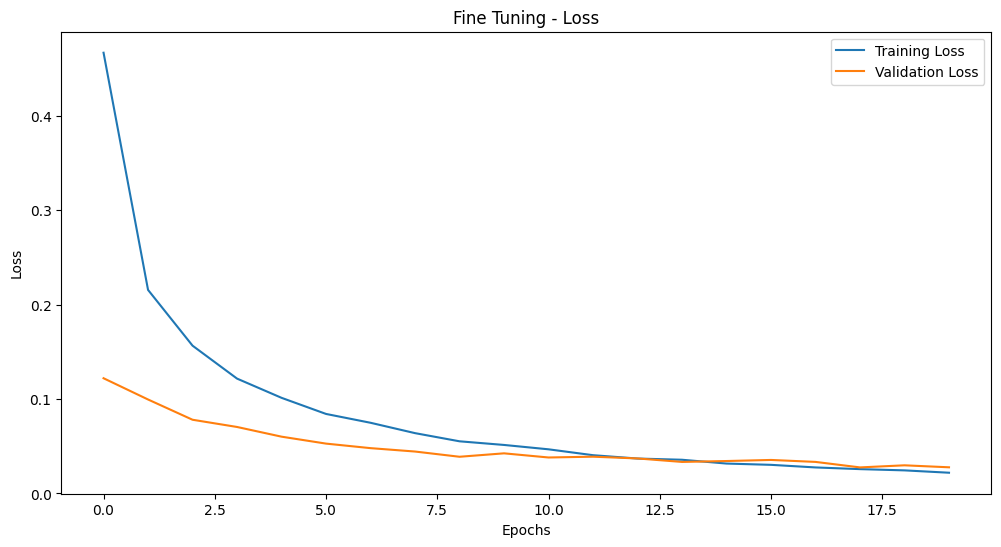

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import json
import matplotlib.pyplot as plt

# Define hyperparameters
img_width, img_height = 224, 224
batch_size = 32
epochs = 20
num_classes = 19

# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    r'C:\Users\AMAN KUMAR\Downloads\MPDDIV4\Plant_Disease_Dataset\train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    r'C:\Users\AMAN KUMAR\Downloads\MPDDIV4\Plant_Disease_Dataset\valid',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained MobileNetV2 model without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Added dropout to reduce overfitting
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(r'C:\Users\AMAN KUMAR\Downloads\MPDDIV4\MobileNetV1 Model\mobilenetv2_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Train the model
print("Training the model...")
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks
)

# Save training history
with open(r'C:\Users\AMAN KUMAR\Downloads\MPDDIV4\MobileNetV1 Model\training_history.json', 'w') as f:
    json.dump(history.history, f)

# Unfreeze the last 50 layers for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model with unfrozen layers
print("Fine-tuning the model...")
fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks
)

# Save fine-tuning history
with open(r'C:\Users\AMAN KUMAR\Downloads\MPDDIV4\MobileNetV1 Model\fine_tune_history.json', 'w') as f:
    json.dump(fine_tune_history.history, f)

# Save the fine-tuned model
model.save(r'C:\Users\AMAN KUMAR\Downloads\MPDDIV4\MobileNetV1 Model\mobilenetv2_fine_tuned_model.keras')

# Visualization of Training History
def plot_training_history(history_file, title):
    with open(history_file, 'r') as f:
        history = json.load(f)
    
    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot initial training history
plot_training_history(r'C:\Users\AMAN KUMAR\Downloads\MPDDIV4\MobileNetV1 Model\training_history.json', 'Initial Training')

# Plot fine-tuning history
plot_training_history(r'C:\Users\AMAN KUMAR\Downloads\MPDDIV4\MobileNetV1 Model\fine_tune_history.json', 'Fine Tuning')


# 2. Evaluating Model

In [2]:
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(train_generator)
print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Optionally, print both losses and accuracies in one line for easy comparison:
print(f'\nTraining Accuracy: {train_accuracy * 100:.2f}% | Validation Accuracy: {val_accuracy * 100:.2f}%')

1115/1115 ━━━━━━━━━━━━━━━━━━━━ 1619s 1s/step - accuracy: 0.9970 - loss: 0.0089
Training Loss: 0.0097, Training Accuracy: 99.67%
279/279 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.9933 - loss: 0.0249
Validation Loss: 0.0276, Validation Accuracy: 99.24%

Training Accuracy: 99.67% | Validation Accuracy: 99.24%


# 3. Accuracy Visualization

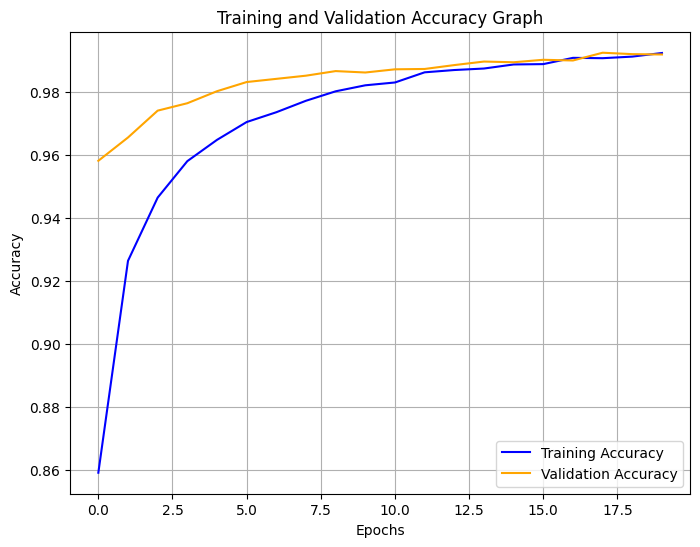

In [7]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy from the fine-tuning history
train_accuracy = fine_tune_history.history['accuracy']
val_accuracy = fine_tune_history.history['val_accuracy']

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 5. Metrics Evaluation

In [5]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# Get true labels and predicted labels from the validation generator
print("Calculating precision, recall, and F1-score...")
validation_generator.reset()  # Reset generator to start evaluation from the beginning

# Predict the labels for the validation data
predictions = model.predict(validation_generator, steps=len(validation_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the generator
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Calculate individual metrics
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Print metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Calculating precision, recall, and F1-score...
279/279 ━━━━━━━━━━━━━━━━━━━━ 223s 798ms/step
Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.99      1.00       504
                                 Apple___Black_rot       0.99      1.00      1.00       497
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       440
                                   Apple___healthy       1.00      1.00      1.00       502
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.95      0.96       410
                       Corn_(maize)___Common_rust_       0.99      1.00      1.00       477
               Corn_(maize)___Northern_Leaf_Blight       0.96      0.97      0.97       477
                            Corn_(maize)___healthy       1.00      1.00      1.00       465
                                 Grape___Black_rot     

# 4. Confusion Matrix Visualization

Found 8917 images belonging to 19 classes.


C:\Users\AMAN KUMAR\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


279/279 ━━━━━━━━━━━━━━━━━━━━ 228s 807ms/step


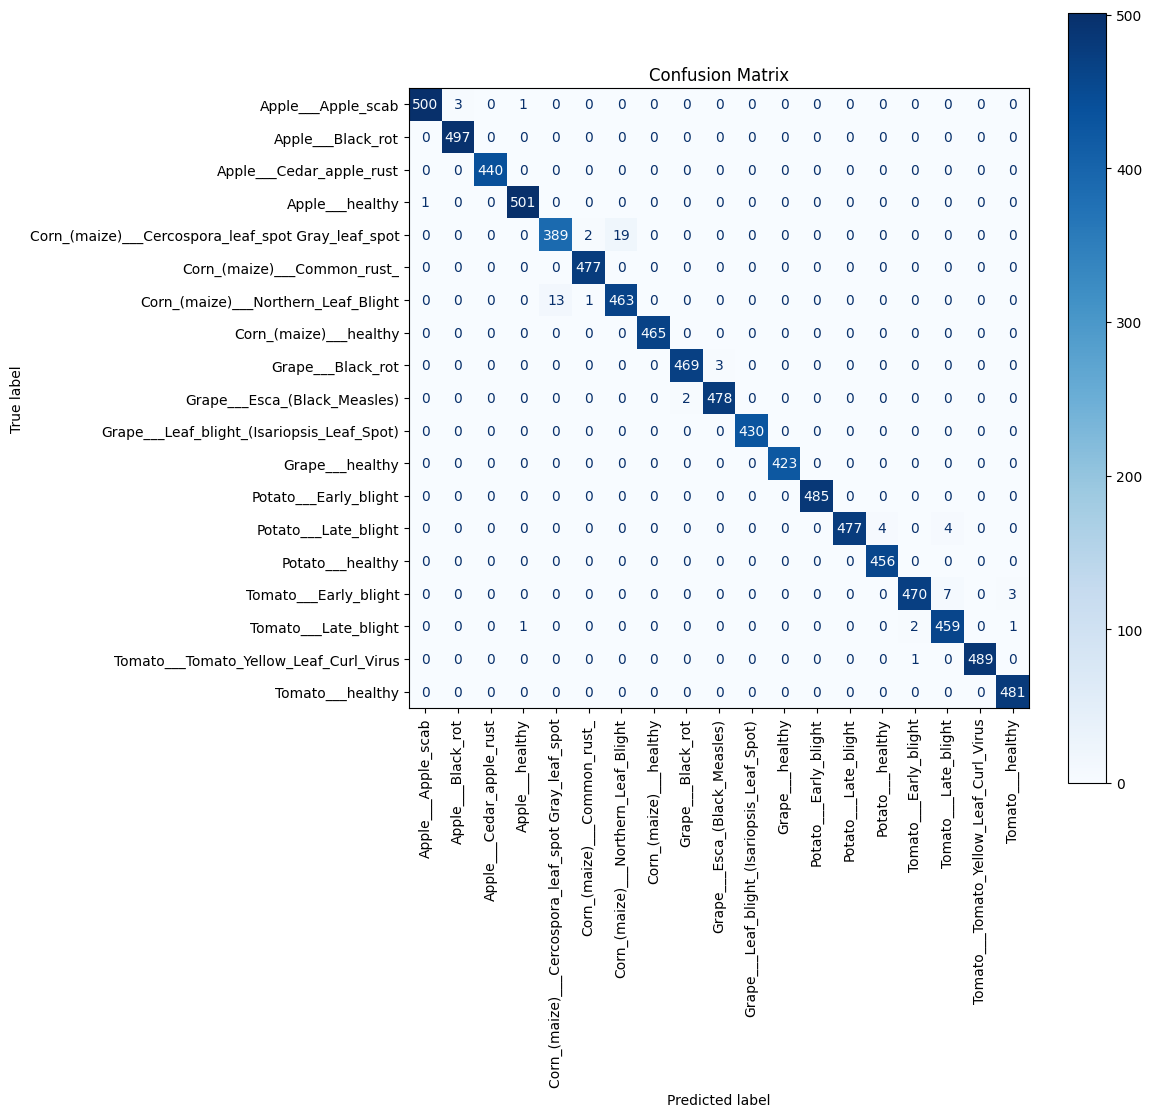

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
img_width, img_height = 224, 224
batch_size = 32
model_path = r"C:\Users\AMAN KUMAR\Downloads\MPDDIV4\MobileNetV1 Model\mobilenetv2_fine_tuned_model.keras"

# Load the saved model
model = load_model(model_path)

# Create the validation data generator
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
    r'C:\Users\AMAN KUMAR\Downloads\MPDDIV4\Plant_Disease_Dataset\valid',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure the order matches with true labels
)

# Generate predictions for the validation data
validation_generator.reset()  # Reset the generator before predictions
predictions = model.predict(validation_generator, steps=len(validation_generator), verbose=1)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the validation generator
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())  # Get class names

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size for clarity
disp.plot(ax=ax, cmap='Blues', colorbar=True)

# Rotate x-axis labels for better visibility
ax.tick_params(axis='x', labelrotation=90)

plt.title("Confusion Matrix")
plt.show()


# 6. Testing Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


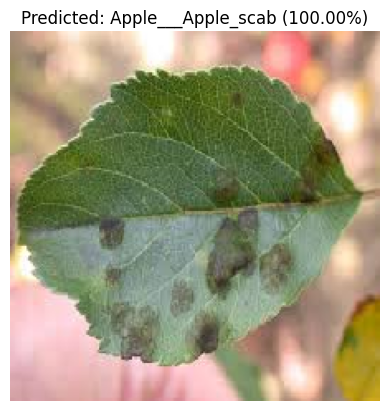

In [130]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt

# Define parameters
img_width, img_height = 224, 224
model_path = r"C:\Users\AMAN KUMAR\Downloads\projectplant\mobilenet\mobi\mobnet_fine_tuned_model.keras"

# Load the saved model
model = load_model(model_path)

# Load and preprocess a test image
test_image_path = r"C:\Users\AMAN KUMAR\Downloads\MPDDIV4\MobileNetV1 Model\Internet_Test_Image\apple_scab_2.jpeg"# Update with the path to your test image
img = image.load_img(test_image_path, target_size=(img_width, img_height))  # Load the image and resize
img_array = image.img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)  # Preprocess for MobileNet

# Make prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)  # Get the index of the highest probability
predicted_probability = np.max(predictions)  # Get the highest probability

# Map class indices to labels (optional if you have class labels)
class_labels = {v: k for k, v in validation_generator.class_indices.items()}  # Reverse the dictionary
predicted_label = class_labels[predicted_class]

# Display the result
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_label} ({predicted_probability:.2%})")
plt.show()
